In [1]:
rm(list = ls())
gc(verbose = FALSE)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,621735,33.3,1352595,72.3,1352595,72.3
Vcells,1152811,8.8,8388608,64.0,1801053,13.8


In [2]:
install.packages("rsample")
install.packages("glmnet")


Installing package into ‘/home/juan_bocco/.local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/home/juan_bocco/.local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
require("rsample")
require("glmnet")
require("dplyr")


library(tidyverse)
library(tidymodels)
library(GGally)
library(cowplot)
library(RColorBrewer)

Loading required package: rsample

Loading required package: glmnet

Loading required package: Matrix

Loaded glmnet 4.1-6

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   0.3.5
✔ tibble  3.1.8     ✔ stringr 1.4.1
✔ tidyr   1.2.1     ✔ forcats 0.5.2
✔ readr   2.1.3     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.1     ✔ recipes      1.0.2
✔ dials        1.1.0     

In [4]:
df <- read.csv("~/buckets/b1/datasets/EEA/join4_with_headers_1_mes.csv")
df <- data.frame(df)

In [5]:
variables_a_eliminar <- c(
  "X",
  "id_consulta",
  "id_usuario",
  "query_string",
  "hora_de_la_consulta",
  "query_clean",
  "query_tokens",
  "query_tokens_stemmed",
  "min_posting_count",
  "max_posting_count",
  "avg_posting_count"
)

df <- df[,!names(df) %in% variables_a_eliminar]


glimpse(df)

Rows: 8,110,088
Columns: 23
$ cantidad_caracteres       <int> 16, 18, 23, 13, 17, 12, 18, 36, 3, 11, 10, 1…
$ numero_de_terminos        <int> 2, 3, 1, 1, 1, 1, 3, 8, 1, 2, 1, 3, 1, 3, 1,…
$ contiene_URL              <int> 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ misspelled                <int> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,…
$ largo_promedio_terminos   <int> 8, 6, 23, 13, 17, 12, 6, 4, 3, 5, 10, 6, 6, …
$ rank_number               <int> 0, 12, 0, 0, 0, 8, 1, 0, 0, 2, 1, 2, 1, 0, 0…
$ hora_consulta             <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ ctr                       <int> 0, 1, 0, 0, 1, 6, 1, 4, 0, 2, 1, 1, 1, 2, 0,…
$ ctr_top                   <int> 0, 0, 0, 0, 0, 0, 1, 3, 0, 1, 1, 0, 1, 1, 0,…
$ cant_consultas_realizadas <int> 1, 1, 1, 1, 4, 7, 1, 8, 2, 3, 1, 1, 1, 5, 2,…
$ max_dia_term              <int> 58, 122, 15, 1, 1, 4, 63, 2525, 161, 151, 7,…
$ min_dia_term              <int> 1, 16, 15, 1, 1, 4, 30, 9, 161, 14, 7, 1, 25…
$ avg_dia_te

In [6]:
#Para evitar los problemas que puede introducir la escala,
#reescalamos las variables con el comando scale

# Reescalamos las variables numericas
df_scaled = df %>% mutate_at(vars(-Clase), scale)

df_scaled$Clase<- recode(df_scaled$Clase, 'Singleton' = 1, 'NoSingleton' =0)

In [7]:
#Realizamos una partición entre dataset de entrenamiento y testeo
#usando la función initial_split del paquete rsample.

train_test <- df_scaled %>% initial_split(prop = 0.7)
train <- training(train_test)
test <- testing(train_test)

frecuencias_train <- table(train$Clase)
prop.table(frecuencias_train)

frecuencias_test <- table(test$Clase)
prop.table(frecuencias_test)


        0         1 
0.5841819 0.4158181 


        0         1 
0.5837342 0.4162658 

In [8]:
#Lasso
#En este caso vamos a trabajar con α=1.

#La función model.matrix crea una matriz de diseño a partir de la fórmula
#definida en el argumento, convirtiendo variables caracter o factor en un conjunto
#de variables dummy. Toma como input un objeto o formula de modelo y un dataset.
#Después de la coerción, todas las variables utilizadas enhttp://34.125.227.158:8888/lab? 
#el lado derecho de la fórmula deben ser lógicas, enteras, numéricas o factores.


# Vector con las Clases (SINGLETON / NO SINGLETON)
df_Clase = train$Clase

# Matriz con los regresores
df_mtx = model.matrix(Clase~., data = train)
dim(df_mtx)

[1] 5677061      23

In [9]:
###   La función glmnet cuenta con los parámetros:
###  
###   x: matriz de variables regresoras
###
###   y: vector de la variable a predecir
###
###   alpha: tipo de modelo (indicador del tipo de regularización)

# Modelo Lasso
lasso.mod = glmnet(x = df_mtx, # Matriz de regresores
                   y = df_Clase, #Vector de la variable a predecir
                   alpha = 1, # Indicador del tipo de regularizacion
                   standardize = FALSE) # Que esta haciendo este parametro ?
# aplicamos la función tidy para obtener los coeficientes del modelo                 
lasso_coef = lasso.mod %>% tidy() %>% arrange(step)
lasso_coef

term,step,estimate,lambda,dev.ratio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1,0.415818150,0.19850816,0.00000000
(Intercept),2,0.415822447,0.18087324,0.02752631
cantidad_caracteres,2,0.017624769,0.18087324,0.02752631
(Intercept),3,0.415826362,0.16480496,0.05037913
cantidad_caracteres,3,0.033683802,0.16480496,0.05037913
(Intercept),4,0.415829930,0.15016414,0.06935195
cantidad_caracteres,4,0.048316195,0.15016414,0.06935195
(Intercept),5,0.415833180,0.13682397,0.08510351
cantidad_caracteres,5,0.061648686,0.13682397,0.08510351


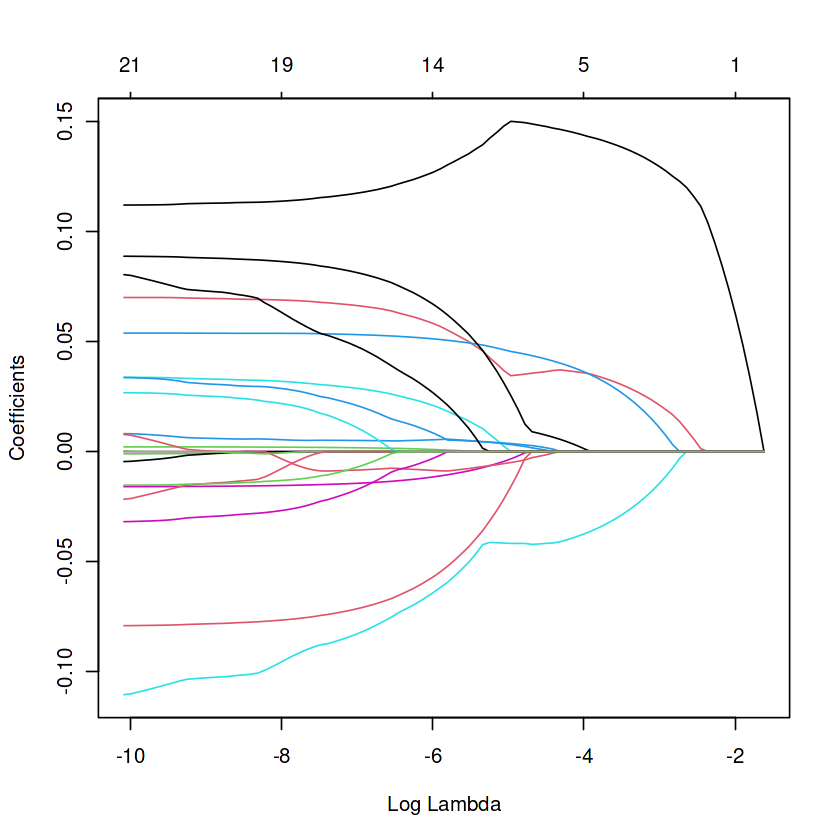

In [10]:
#Gráficos de análisis
#El comando plot nos permite realizar dos gráficos relevantes.
#Gráfico de coeficientes en función del lambda

plot(lasso.mod, 'lambda')

In [11]:
#Veamos ahora cuáles variables sobreviven para mayores valores de lambda.

# Seleccionamos los terminos que sobreviven para valores altos de lambda
terminos_sobrevientes = lasso_coef %>% 
  filter(log(lambda)>-5.5, term != "(Intercept)") %>%
  select(term) %>% 
  distinct() %>% 
  pull()

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


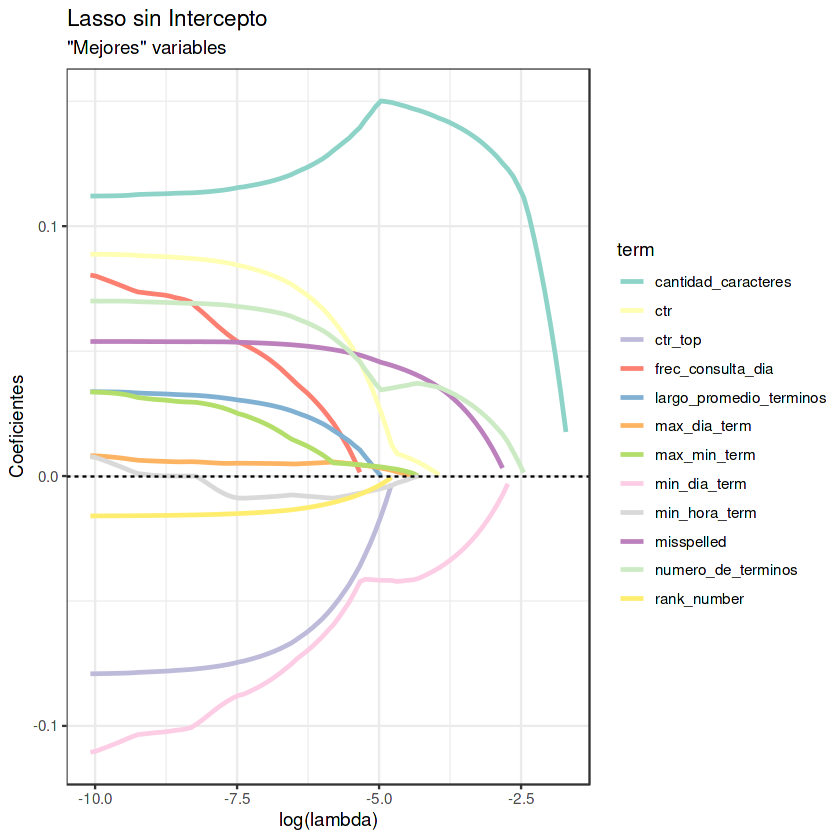

In [12]:
# Graficamos
lasso_coef %>% 
  filter(term %in% terminos_sobrevientes) %>% 
  ggplot(., aes(log(lambda), estimate, group=term, color=term)) +
  geom_line(size=1)  +
  scale_colour_manual(values=rep(brewer.pal(12,"Set3"),times=2))+
  #   scale_color_brewer(palette = mycolors) +
  geom_hline(yintercept = 0, linetype='dashed') +
  theme_bw() +
  labs(title="Lasso sin Intercepto", y="Coeficientes", subtitle= "\"Mejores\" variables")

# Elección del lambda óptimo

In [13]:
#Para elegir el valor óptimo de lambda, lo común es realizar cross-validation. La función cv.glmnet nos permite realizar esto de manera sencilla.
#
#Al igual que para la función glmnet cuenta con los parámetros x, y, alpha y standardize, incluyendo un nuevo parámetro:
#  
#  type.measure: función de pérdida/error que se va a utilizar en CV. Para los modelos de regularización el default es MSE.
#Salida Base

lasso_cv = cv.glmnet(x = df_mtx, 
                     y = df_Clase, 
                     alpha = 1, 
                     standardize = T)
summary(lasso_cv)

           Length Class  Mode     
lambda     92     -none- numeric  
cvm        92     -none- numeric  
cvsd       92     -none- numeric  
cvup       92     -none- numeric  
cvlo       92     -none- numeric  
nzero      92     -none- numeric  
call        5     -none- call     
name        1     -none- character
glmnet.fit 12     elnet  list     
lambda.min  1     -none- numeric  
lambda.1se  1     -none- numeric  
index       2     -none- numeric  

## Plot

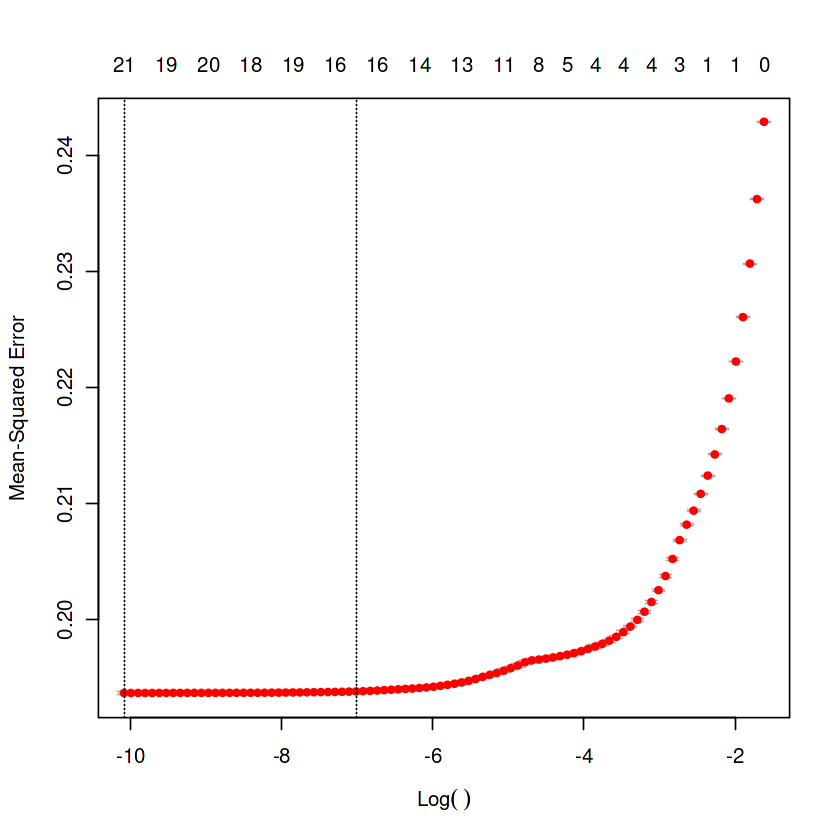

In [14]:
#Gráfico Base

plot(lasso_cv)

## Lambda óptimo

In [15]:
#Seleccionamos el lambda óptimo para crear el modelo final.

# Selección lambda óptimo
lasso_lambda_opt = lasso_cv$lambda.min
# Entrenamiento modelo óptimo
lasso_opt = glmnet(x = df_mtx, # Matriz de regresores
                   y = df_Clase, # Vector de la variable a predecir
                   alpha = 1, # Indicador del tipo de regularizacion
                   standardize = TRUE, # Estandarizamos
                   lambda = lasso_lambda_opt)
# Salida estandar
lasso_opt

# Tidy
lasso_opt %>% tidy()

a <- as.data.frame(lasso_opt %>% tidy())



Call:  glmnet(x = df_mtx, y = df_Clase, alpha = 1, lambda = lasso_lambda_opt,      standardize = TRUE) 

  Df  %Dev    Lambda
1 21 20.26 4.177e-05

term,step,estimate,lambda,dev.ratio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1,0.4158942268,4.177204e-05,0.2026399
cantidad_caracteres,1,0.1121633292,4.177204e-05,0.2026399
numero_de_terminos,1,0.0699088476,4.177204e-05,0.2026399
contiene_URL,1,-0.0010161400,4.177204e-05,0.2026399
misspelled,1,0.0538549090,4.177204e-05,0.2026399
largo_promedio_terminos,1,0.0336858981,4.177204e-05,0.2026399
rank_number,1,-0.0159606581,4.177204e-05,0.2026399
ctr,1,0.0888249270,4.177204e-05,0.2026399
ctr_top,1,-0.0791701139,4.177204e-05,0.2026399


In [18]:
print(paste(lasso_cv$lambda.min, log(lasso_cv$lambda.min)))
print(paste(lasso_cv$lambda.1se, log(lasso_cv$lambda.1se)))

[1] "4.17720398099177e-05 -10.0832833463187"
[1] "0.000899951316398795 -7.01316988899326"


In [19]:
coef(lasso_cv, c(lasso_cv$lambda.min, lasso_cv$lambda.1se))

24 x 2 sparse Matrix of class "dgCMatrix"
                                     s1           s2
(Intercept)                4.158943e-01  0.415893457
(Intercept)                .             .          
cantidad_caracteres        1.120628e-01  0.117398386
numero_de_terminos         7.004008e-02  0.066401251
contiene_URL              -1.040419e-03  .          
misspelled                 5.384888e-02  0.053171744
largo_promedio_terminos    3.376209e-02  0.028792729
rank_number               -1.595957e-02 -0.014446242
hora_consulta              .             .          
ctr                        8.879060e-02  0.081438332
ctr_top                   -7.914241e-02 -0.071557099
cant_consultas_realizadas  2.126414e-03  0.001736972
max_dia_term               8.153357e-03  0.005050017
min_dia_term              -1.105122e-01 -0.083003358
avg_dia_term              -2.908487e-06  .          
max_hora_term             -4.555070e-03  .          
min_hora_term              7.757110e-03 -0.008422025
avg_